In [47]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as np
import matplotlib.pyplot as plt

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        try:
            yield eval(l)
        except:
            continue

In [18]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [19]:
dataset = []
for d in readGz("renttherunway_final_data.json.gz"):
    dataset.append(d)


In [20]:
len(dataset)

192462

In [21]:
def heightConversion(h):
    ft, inch = h.split('\' ')
    ft = int(ft)
    inch = int(inch.replace('\"', ''))
    return ft * 12 + inch

In [22]:
new_dataset = []
punctuation = set(string.punctuation)

for d in dataset:
    feature_needed = ['weight', 'height', 'fit', 'size', 'body type', 'review_text', 'review_summary', 'rating']
    keys = list(d.keys())
    if all([i in keys for i in feature_needed]):
        d['weight'] = int(d['weight'].replace("lbs", ""))
        d['height'] = heightConversion(d['height'])
        new_dataset.append(d)

In [23]:
len(new_dataset)

153441

In [68]:
y1 = [d['fit'] for d in new_dataset]

In [69]:
dataTrain1, data_vt1, ytrain1, y_vt1 = train_test_split(new_dataset, y1, test_size=0.3, random_state=42)
dataValid1, dataTest1, yvalid1, ytest1 = train_test_split(data_vt1, y_vt1, test_size=0.5, random_state=42)
len(dataTrain1), len(dataValid1), len(dataTest1)

(107408, 23016, 23017)

In [70]:
Xtrain1 = [[1, d['weight'], d['height'], d['size']] for d in dataTrain1]
Xvalid1 = [[1, d['weight'], d['height'], d['size']] for d in dataValid1]
Xtest1 = [[1, d['weight'], d['height'], d['size']] for d in dataTest1]

In [27]:
def accuracy(pred, y):
    correct = pred == y
    return sum(correct)/len(y)

In [79]:
# Baseline Model - using only weight, height and size
cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
mods = {}
accsVal = {}
accsTrain = {}
accura = []
for i in cs:
    baselineMod = linear_model.LogisticRegression(C=i)
    baselineMod.fit(Xtrain1,ytrain1)
    mods[i] = baselineMod
    blPred = baselineMod.predict(Xvalid1)
    blacc = accuracy(blPred, yvalid1)
    accsVal[i] = blacc
    blPredTr = baselineMod.predict(Xtrain1)
    blaccTr = accuracy(blPredTr, ytrain1)
    accsTrain[i] = blaccTr
    print("C = {}, accuracy is {}.".format(str(i), str(blacc)))

C = 1e-05, accuracy is 0.7337504344803615.
C = 0.0001, accuracy is 0.7332725060827251.
C = 0.001, accuracy is 0.7330552659019812.
C = 0.01, accuracy is 0.73309871393813.
C = 0.1, accuracy is 0.7330552659019812.
C = 1, accuracy is 0.7330552659019812.
C = 10, accuracy is 0.7330552659019812.
C = 100, accuracy is 0.7330552659019812.


In [80]:
bestMod = mods[0.00001]
predTest = bestMod.predict(Xtest1)
accTest1 = accuracy(predTest, ytest1)
accTest1

0.739105878263892

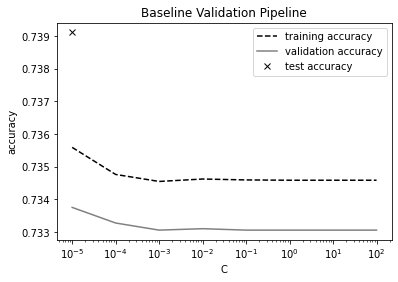

In [81]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"accuracy")
plt.title(r"Baseline Validation Pipeline")
plt.xscale('log')
plt.plot(cs, list(accsTrain.values()), color='k', linestyle='--', label='training accuracy')
plt.plot(cs, list(accsVal.values()), color='grey',zorder=4,label="validation accuracy")
plt.plot([0.00001], [accTest1], linestyle='', marker='x', color='k', label="test accuracy")
plt.legend(loc='best')
plt.show()

In [30]:
y = [d['fit'] for d in dataset]

In [31]:
dataTrain, data_vt, ytrain, y_vt = train_test_split(dataset, y, test_size=0.3, random_state=42)
dataValid, dataTest, yvalid, ytest = train_test_split(data_vt, y_vt, test_size=0.5, random_state=42)
len(dataTrain), len(dataValid), len(dataTest)

(134723, 28869, 28870)

In [32]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
sw = stopwords.words("English")
for d in dataTrain:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1

len(wordCount)

32111

In [33]:
counts = [(wordCount[w],w) for w in wordCount if w not in sw]
counts.sort()
counts.reverse()
len(counts)

31996

In [34]:
words = [x[1] for x in counts[:5000]]

In [35]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [36]:
max_rating = float('-inf')
min_rating = float('inf')
for d in dataset:
    max_rating = max(int(d['rating']), max_rating)
    min_rating = min(int(d['rating']), min_rating)
max_rating, min_rating

(10, 2)

In [37]:
def feature(d): 
    feat = [0]*len(words)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat[wordId[w]] += 1
    feat2 = [0]*(max_rating-min_rating+1)
    feat2[max_rating-int(d['rating'])] = 1
    return [1] + feat + feat2[1:]

In [38]:
Xtrain = [feature(d) for d in dataTrain]

In [39]:
Xvalid = [feature(d) for d in dataValid]

In [40]:
Xtest= [feature(d) for d in dataTest]

In [43]:
# Track the model which works best on the validation set
bestModel = None
bestVal = None
bestC = None
models = dict()
accValid = dict()
accTrain = dict()
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in Cs:
    model = linear_model.LogisticRegression(C=c)
    model.fit(Xtrain, ytrain)
    models[c] = model
    predictValid = model.predict(Xvalid)
    accV = accuracy(predictValid, yvalid)
    accValid[c] = accV
    predictTrain = model.predict(Xtrain)
    accT = accuracy(predictTrain, ytrain)
    accTrain[c] = accT
    print("C = " + str(c) + ", validation accuracy = " + str(accV))
    if bestVal == None or accV > bestVal:
        bestVal = accV
        bestModel = model
        bestC = c

C = 0.001, validation accuracy = 0.7895666632027434
C = 0.01, validation accuracy = 0.8049118431535557
C = 0.1, validation accuracy = 0.8048772039211611
C = 1, validation accuracy = 0.8023831791887491
C = 10, validation accuracy = 0.8013093629845163
C = 100, validation accuracy = 0.8007204960338079
C = 1000, validation accuracy = 0.8023485399563546


In [60]:
predictTest = bestModel.predict(Xtest)
accTest = accuracy(predictTest, ytest)
accTest

0.7956702459300312

In [49]:
accTrain

{0.001: 0.790540590693497,
 0.01: 0.807998634234689,
 0.1: 0.8138476726319931,
 1: 0.814820038152357,
 10: 0.8154954981703199,
 100: 0.8149981814537978,
 1000: 0.8145973590255562}

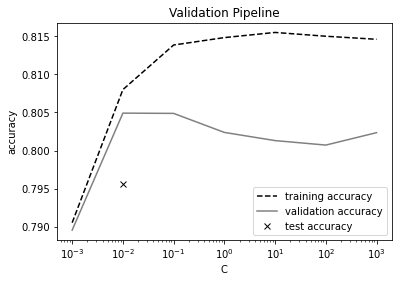

In [64]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"accuracy")
plt.title(r"Validation Pipeline")
plt.xscale('log')
plt.plot(Cs, list(accTrain.values()), color='k', linestyle='--', label='training accuracy')
plt.plot(Cs, list(accValid.values()), color='grey',zorder=4,label="validation accuracy")
plt.plot([bestC], [accTest], linestyle='', marker='x', color='k', label="test accuracy")
plt.legend(loc='best')
plt.show()